# celltalker

**Language:** R

**Code Resource:** https://github.com/arc85/celltalker

**Claiming:** Inference of intercellular signaling networks (ligand-receptor)

**Method:** Based on expression threshod of ligands and receptors within and between clusters of cells across experimental groups

**Database:** Set of ligands and receptors described by the work of Ramilowski et al (Nature Communications, 2015)


## Input
1. scRNA-seq data: gene-expression matrix (normalized) with rows as genes and columns as cells
2. cell type annotation

In this vignette, we demonstrate a basic use of cellTalker to evaluate putative ligand/receptor interactions in peripheral blood (N=2) and tonsils from healthy donors (N=3). This data is publically available from our recently published dataset (Cillo et al, Immunity 2020) on the NCBI Gene Expression Omnibus Series GSE139324.

Download link: https://zenodo.org/record/5059735/files/data_matrices.zip?download=1

### Installation

In [ ]:
library(devtools)
install_github("arc85/celltalker")
library(celltalker)

### Clustering data with Seurat
This tutorial begins with a standard clustering analysis and identification of immune lineages in Seurat

In [1]:
library(Seurat)
library(celltalker)
#Set seed for reproducibility

set.seed(02221989)

Attaching SeuratObject

Loading required package: tidyverse

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: circlize

circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://joker

In [2]:
sample_dir <- list.files("data_matrices")
data_dir <- paste("data_matrices",sample_dir, sep="/")
data.paths <- list.files(data_dir)
raw.data <- Read10X(data.dir=data_dir)

In [3]:
# build metadata
sample.data <- data.frame(matrix(data=NA,nrow=ncol(raw.data),ncol=2))
rownames(sample.data) <- colnames(raw.data)
colnames(sample.data) <- c("sample.id","sample.type")
sample.data[grep("^1",rownames(sample.data)),"sample.id"] <- "pbmc_1"
sample.data[grep("^2",rownames(sample.data)),"sample.id"] <- "tonsil_1"
sample.data[grep("^3",rownames(sample.data)),"sample.id"] <- "pbmc_2"
sample.data[grep("^4",rownames(sample.data)),"sample.id"] <- "tonsil_2"
sample.data[grep("^5",rownames(sample.data)),"sample.id"] <- "pbmc_3"
sample.data[grep("^6",rownames(sample.data)),"sample.id"] <- "tonsil_3"
sample.data[,"sample.type"] <- sapply(strsplit(sample.data$sample.id,split="_"),function(x) x[1])

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix

PC_ 1 
Positive:  S100A6, IL32, S100A4, ANXA1, VIM, FTL, TRBC1, SRGN, S100A9, S100A8 
	   TYROBP, LYZ, CTSW, XIST, NEAT1, VCAN, S100A12, FCER1G, S100A11, FCN1 
	   PLAC8, ID2, CCL5, NKG7, CST3, CSTA, ZFP36, IL1B, MT2A, KLRB1 
Negative:  RGS13, KIAA0101, NUSAP1, AURKB, MKI67, BIRC5, TYMS, TOP2A, TK1, CDKN3 
	   UBE2C, PTTG1, CDK1, STMN1, CCNB2, GTSE1, BIK, RRM2, TCL1A, SHCBP1 
	   CDCA3, CDC20, TPX2, LRMP, CCNA2, MND1, CCNB1, PBK, ZWINT, RMI2 
PC_ 2 
Positive:  CST3, LYZ, FCN1, CSTA, S100A9, S100A8, TYROBP, LST1, FGL2, VCAN 
	   S100A12, SERPINA1, MNDA, FCER1G, CLEC7A, MS4A6A, CD14, CFD, IL1B, TYMP 
	   LGALS1, RP11-1143G9.4, AIF1, CTSS, NAMPT, CFP, TNFSF13B, CSF3R, MPEG1, TMEM176B 
Negative:  IL32, NPM1, CD69, TRBC1, ISG20, ITM2A, IGKC, IGHA1, HSP90AB1, DDIT4 
	   HIST1H4C, PSIP1, AQP3, MYC, PIM2, HMGN1, PASK, NUCB2, HSPA1B, HSPB1 
	   CD79A, SUSD3, KLRB1, SYNE

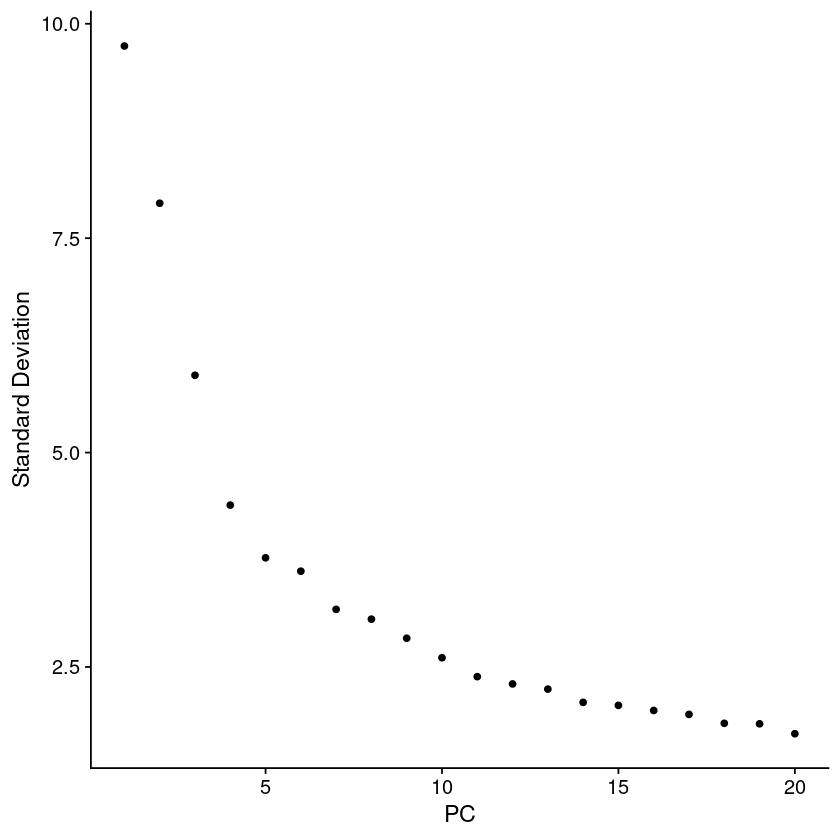

In [4]:
# build and analysis the seurat object
ser.obj <- CreateSeuratObject(counts=raw.data,meta.data=sample.data)
ser.obj <- NormalizeData(ser.obj)
ser.obj <- FindVariableFeatures(ser.obj)
ser.obj <- ScaleData(ser.obj)
ser.obj <- RunPCA(ser.obj)
ElbowPlot(ser.obj)
ser.obj <- RunUMAP(ser.obj,reduction="pca", dims=1:15)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15524
Number of edges: 542366

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9182
Number of communities: 16
Elapsed time: 2 seconds


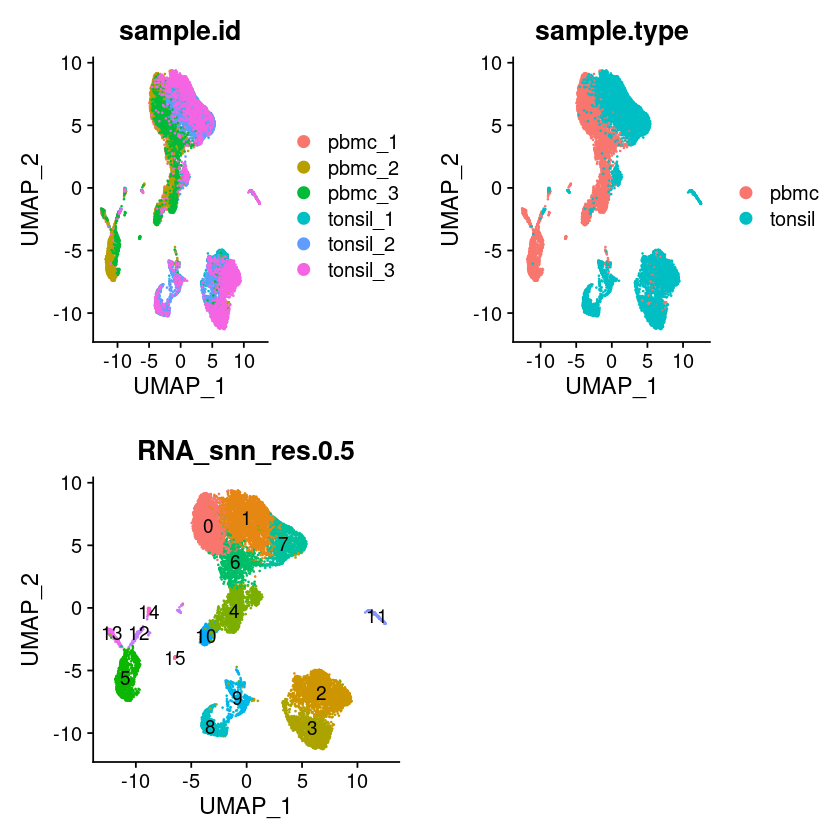

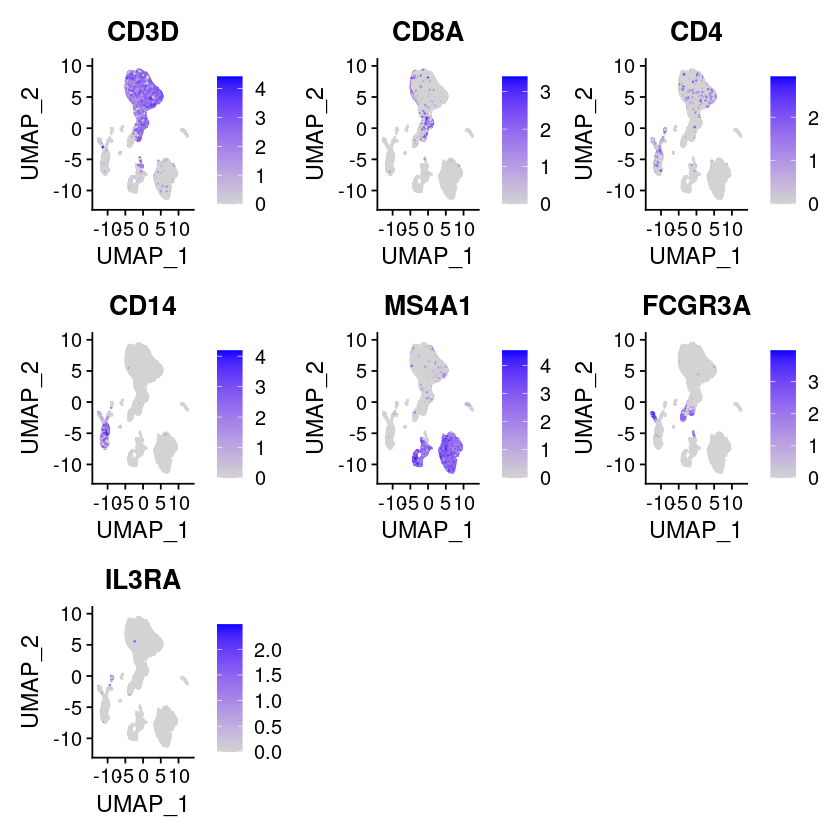

In [5]:
## computing nearest neighbor graph
ser.obj <- FindNeighbors(ser.obj,reduction="pca",dims=1:15)
## computing SNN
ser.obj <- FindClusters(ser.obj,resolution=0.5)
p1 <- DimPlot(ser.obj,reduction="umap",group.by="sample.id")
p2 <- DimPlot(ser.obj,reduction="umap",group.by="sample.type")
p3 <- DimPlot(ser.obj,reduction="umap",group.by="RNA_snn_res.0.5",label=T) + NoLegend()
cowplot::plot_grid(p1,p2,p3)
FeaturePlot(ser.obj,reduction="umap",features=c("CD3D","CD8A","CD4","CD14","MS4A1","FCGR3A","IL3RA"))

In [6]:
# add cell types annotation
cell.types <- vector("logical",length=ncol(ser.obj))
names(cell.types) <- colnames(ser.obj)
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="0"] <- "cd4.tconv"
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="1"] <- "cd4.tconv"
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="2"] <- "b.cells"
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="3"] <- "b.cells"
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="4"] <- "cd8.cells"
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="5"] <- "cd14.monocytes"
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="6"] <- "cd4.tconv"
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="7"] <- "cd4.tconv"
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="8"] <- "b.cells"
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="9"] <- "b.cells"
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="10"] <- "nk.cells"
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="11"] <- "plasma.cells"
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="12"] <- "cd14.monocytes"
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="13"] <- "cd16.monocytes"
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="14"] <- "pdc"
cell.types[ser.obj@meta.data$RNA_snn_res.0.5=="15"] <- "RBCs"
ser.obj[["cell.types"]] <- cell.types

In [7]:
# remove cells that we don't need
rbc.cell.names <- names(cell.types)[ser.obj@meta.data$RNA_snn_res.0.5=="15"]
nk.cell.names <- names(cell.types)[ser.obj@meta.data$RNA_snn_res.0.5=="10"]
cd16.cell.names <- names(cell.types)[ser.obj@meta.data$RNA_snn_res.0.5=="13"]
ser.obj <- ser.obj[,!colnames(ser.obj) %in% rbc.cell.names]
ser.obj <- ser.obj[,!colnames(ser.obj) %in% nk.cell.names]
ser.obj <- ser.obj[,!colnames(ser.obj) %in% cd16.cell.names]

### Consistently expressed ligands and receptors

In [8]:
head(ramilowski_pairs)

,ligand,receptor,pair
,<fct>,<fct>,<fct>
1,A2M,LRP1,A2M_LRP1
2,AANAT,MTNR1A,AANAT_MTNR1A
3,AANAT,MTNR1B,AANAT_MTNR1B
4,ACE,AGTR2,ACE_AGTR2
5,ACE,BDKRB2,ACE_BDKRB2
6,ADAM10,AXL,ADAM10_AXL


In [9]:
ligs <- as.character(unique(ramilowski_pairs$ligand))
recs <- as.character(unique(ramilowski_pairs$receptor))
ligs.present <- rownames(ser.obj)[rownames(ser.obj) %in% ligs]
recs.present <- rownames(ser.obj)[rownames(ser.obj) %in% recs]
genes.to.use <- union(ligs.present,recs.present)
Idents(ser.obj) <- "sample.type"
markers <- FindAllMarkers(ser.obj, assay="RNA",features=genes.to.use,only.pos=TRUE)

Calculating cluster pbmc

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster tonsil



In [10]:
ligs.recs.use <- unique(markers$gene)
length(ligs.recs.use)

[1] 76

In [21]:
#Yields 76 ligands and receptors to evaluate
#Filter ramilowski pairs
interactions.forward1 <- ramilowski_pairs[as.character(ramilowski_pairs$ligand) %in% ligs.recs.use,]
interactions.forward2 <- ramilowski_pairs[as.character(ramilowski_pairs$receptor) %in% ligs.recs.use,]
interact.for <- rbind(interactions.forward1, interactions.forward2)
dim(interact.for)

[1] 314   3

In [22]:
#Yields 314 ligand and receptor interactions to evaluate
#Create data for celltalker
expr.mat <- GetAssayData(ser.obj,slot="counts")
defined.clusters <- ser.obj@meta.data$cell.types
defined.groups <- ser.obj@meta.data$sample.type
defined.replicates <- ser.obj@meta.data$sample.id
reshaped.matrices <- reshape_matrices(count.matrix=expr.mat,clusters=defined.clusters,groups=defined.groups,replicates=defined.replicates,ligands.and.receptors=interact.for)

In [24]:
names(pull(unnest(reshaped.matrices,cols="samples"))[[1]])

[1] "b.cells"        "cd14.monocytes" "cd4.tconv"      "cd8.cells"     
[5] "pdc"            "plasma.cells"

What we have done in this initial step is to separate our overall expression matrix into a series of individual expression matrices from each sample. Next, we can create a tibble of consistently expressed ligands and receptors for each group using the create_lig_rec_tib function.

In [27]:
consistent.lig.recs <- create_lig_rec_tib(exp.tib=reshaped.matrices,clusters=defined.clusters,groups=defined.groups,replicates=defined.replicates,cells.reqd=10,freq.pos.reqd=0.5,ligands.and.receptors=interact.for)

In [28]:
pull(unnest(consistent.lig.recs[1,2],cols="lig.rec.exp")[1,2])[[1]]

$ligands
 [1] "S100A9"   "S100A8"   "IL1B"     "FN1"      "BTLA"     "SPON2"   
 [7] "LRPAP1"   "AREG"     "VCAN"     "CD14"     "LY86"     "HLA-G"   
[13] "HLA-A"    "HLA-E"    "HLA-B"    "LTA"      "TNF"      "LTB"     
[19] "HSPA1A"   "CD24"     "NAMPT"    "TIMP1"    "CD40LG"   "ADAM28"  
[25] "PNOC"     "IL7"      "ANXA1"    "SEMA4D"   "VIM"      "PSAP"    
[31] "LYZ"      "SELPLG"   "HMGB1"    "ALOX5AP"  "TNFSF13B" "GZMB"    
[37] "PSEN1"    "CALM1"    "SERPINA1" "HSP90AA1" "B2M"      "PKM"     
[43] "IL16"     "CCL5"     "CCL3"     "CCL4"     "ICAM2"    "CD70"    
[49] "ICAM1"    "ICAM3"    "CALR"     "TGFB1"    "VASP"     "FLT3LG"  
[55] "APP"     

$receptors
 [1] "TNFRSF14"  "TNFRSF1B"  "CSF3R"     "TGFBR3"    "KCNA3"     "CD53"     
 [7] "CD1A"      "CD247"     "SELL"      "CXCR4"     "ITGA4"     "GRM7"     
[13] "TGFBR2"    "CCR5"      "TFRC"      "TLR1"      "IL7R"      "CD180"    
[19] "ADRB2"     "CD74"      "HMMR"      "HLA-F"     "KCNQ5"     "IGF2R"    
[25] "CCR6"      "CD36"      "ORAI2"     "CXCR3"     "NGFRAP1"   "PGRMC1"   
[31] "CD72"      "TGFBR1"    "ABCA1"     "IFITM1"    "CD81"      "KCNQ1"    
[37] "CD44"      "CD82"      "IL10RA"    "CD3D"      "CD3G"      "CXCR5"    
[43] "SORL1"     "APLP2"     "ITGB1"     "ALOX5"     "FAS"       "CD27"     
[49] "CD4"       "KLRG1"     "CLEC2B"    "KLRD1"     "KLRC1"     "PDE1B"    
[55] "CD63"      "TRAF3"     "TNFRSF17"  "CD19"      "ITGAL"     "ITGAM"    
[61] "TNFRSF13B" "ERBB2"     "ITGA3"     "PECAM1"    "PTPRA"     "CD40"     
[67] "OPRL1"     "INSR"      "TYROBP"    "CD79A"     "KCNN4"     "FPR2"     
[73] "LILRB2"    "LILRB1"    "KIR2DL3"   "KIR2DL1"   "KIR3DL2"   "IL17RA"   
[79] "TNFRSF13C" "CELSR1"    "ITGB2"

We can see that we have now recovered a list of consistently expressed ligands and receptors from each cluster in each experimental group, based on the criteria specified above (i.e. at least 10 cells in each cluster express the ligand/receptor and at least 50% of replicates in a group express the ligand/receptor).

### Determine putative ligand/receptor pairs
Now that we have consistently expressed ligands and receptors, we will look for interactions (as defined in ramilowski_pairs$pair) within and between clusters in a given group. The parameter “freq.group.in.cluster” allows us to only examine clusters that consist of (in this case) >5% of cells from a given group for interactions.

In [29]:
put.int <- putative_interactions(ligand.receptor.tibble=consistent.lig.recs,clusters=defined.clusters,groups=defined.groups,freq.group.in.cluster=0.05,ligands.and.receptors=interact.for)

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(lig.rec.exp)`”
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(lig.rec.exp)`”


### Identifying and visualizing unique ligand/receptor pairs in a group

Now that we have our lists of ligand/receptor interactions, we can investigate which one are unique to each group (using the unique_interactions function) and plot the results (using the circos_plot function) to visualize the differences between groups.

Note: 1 point is out of plotting region in sector 'b.cells', track '1'.

Note: 1 point is out of plotting region in sector 'cd14.monocytes',
track '1'.

Note: 1 point is out of plotting region in sector 'cd4.tconv', track
'1'.

Note: 1 point is out of plotting region in sector 'cd8.cells', track
'1'.

Note: 1 point is out of plotting region in sector 'pdc', track '1'.

Note: 1 point is out of plotting region in sector 'plasma.cells', track
'1'.



[1] "Plotted interactions"


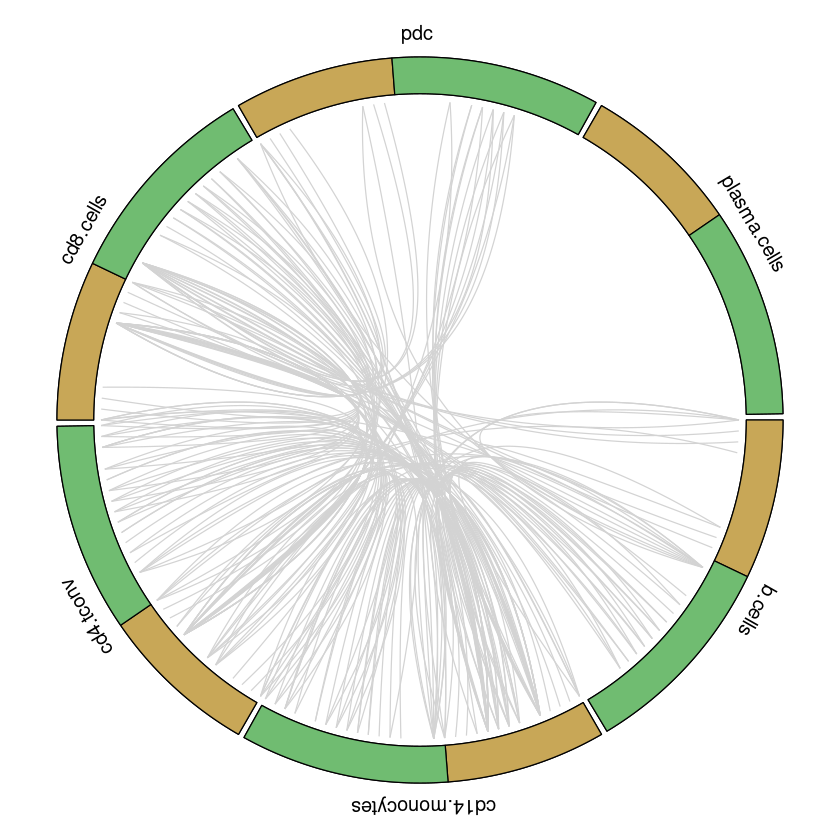

In [31]:
#Identify unique ligand/receptor interactions present in each sample
unique.ints <- unique_interactions(put.int,group1="pbmc",group2="tonsil",interact.for)
#Get data to plot circos for PBMC
pbmc.to.plot <- pull(unique.ints[1,2])[[1]]
for.circos.pbmc <- pull(put.int[1,2])[[1]][pbmc.to.plot]

circos_plot(interactions=for.circos.pbmc,clusters=defined.clusters)

Note: 1 point is out of plotting region in sector 'b.cells', track '1'.

Note: 1 point is out of plotting region in sector 'cd14.monocytes',
track '1'.

Note: 1 point is out of plotting region in sector 'cd4.tconv', track
'1'.

Note: 1 point is out of plotting region in sector 'cd8.cells', track
'1'.

Note: 1 point is out of plotting region in sector 'pdc', track '1'.

Note: 1 point is out of plotting region in sector 'plasma.cells', track
'1'.



[1] "Plotted interactions"


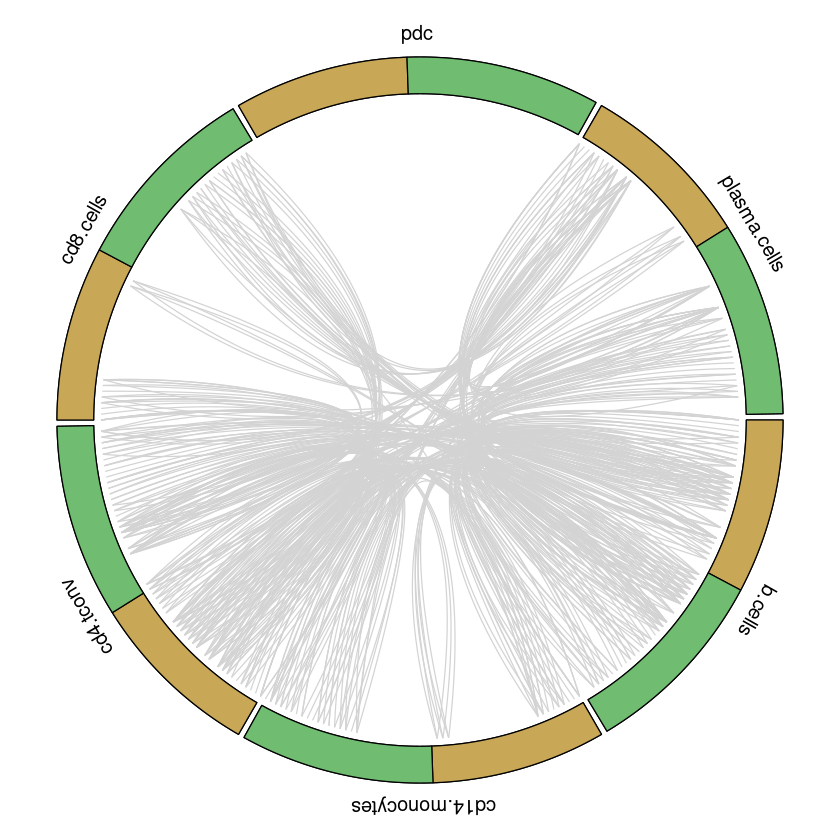

In [32]:
#Get data to plot circos for tonsil
tonsil.to.plot <- pull(unique.ints[2,2])[[1]]
for.circos.tonsil <- pull(put.int[2,2])[[1]][tonsil.to.plot]

circos_plot(interactions=for.circos.tonsil,clusters=defined.clusters)

Last updated: June 12,2021 